# Introduction to some forms of parallelism

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

## Threading

In [ ]:
import threading as th

### Sleep exemple

In [18]:
def run(function, input_list, verbose=True):
    results = {}
    def __wrapped_run(val):
        results[val] = function(val)

    threads = []
    start = time.time()
    for val in input_list:
        threads.append(th.Thread(target=__wrapped_run, daemon=True, args=[val]))
        threads[-1].start()
        if verbose: print(f'Starting [{threads[-1].name}] - x: {val}')
    for i, thread in enumerate(threads):
        thread.join()
        stop = time.time()
        if verbose: print(f'Finishing [{thread.name}] - y: {results[input_list[i]]} - elapsed time: {(stop-start):.2f} s')
    return [results[val] for val in input_list]

In [27]:
%%time
x = [10, 15, 20, 30]
run(time.sleep, x, verbose=True)

Starting [Thread-98 (__wrapped_run)] - x: 10
Starting [Thread-99 (__wrapped_run)] - x: 15
Starting [Thread-100 (__wrapped_run)] - x: 20
Starting [Thread-101 (__wrapped_run)] - x: 30
Finishing [Thread-98 (__wrapped_run)] - y: None - elapsed time: 10.00 s
Finishing [Thread-99 (__wrapped_run)] - y: None - elapsed time: 15.00 s
Finishing [Thread-100 (__wrapped_run)] - y: None - elapsed time: 20.00 s
Finishing [Thread-101 (__wrapped_run)] - y: None - elapsed time: 30.00 s
CPU times: user 10 ms, sys: 37 µs, total: 10 ms
Wall time: 30 s


[None, None, None, None]

In [80]:
%%time
{val: time.sleep(val) for val in x}

CPU times: user 474 µs, sys: 3.92 ms, total: 4.4 ms
Wall time: 1min 15s


{10: None, 15: None, 20: None, 30: None}

## Multiprocessing

In [57]:
from multiprocessing import Pool

### $\pi$ estimation exemple

Given a circle region $C$ of radius $R$, centred on origin, and arbitrary values $x, y \in [0, R]$,
$$
R^2 p((x, y) \in C) = \frac{\pi R^2}{4} \longrightarrow \pi = 4p((x, y) \in C),
$$
cosiderating
$$
p((x, y) \in C) = \lim_{N \to \infty} \frac{\sum_{i}^N g(\sqrt{x_i^2 + y_i^2})}{N},
$$
where
$$
g(r) = \left\{
    \begin{array}{rl}
        1, & r \le 1\\
        0, & r > 1
    \end{array}
\right..
$$

In [3]:
from random import random

def get_pi(N):
    return 4*sum([int(np.sqrt(random()**2 + random()**2) <= 1) for _ in range(N)])/N

In [69]:
def timeit(func, *args, **kwargs):
    start = time.time()
    y = func(*args, **kwargs)
    stop = time.time()
    return stop-start, y

$$
p((x, y) \in C) = \lim_{N \to \infty} \frac{\sum_{i}^N g(\sqrt{x_i^2 + y_i^2})}{N}
= 
\frac{\sum_{i}^{n_1} g(\sqrt{x_i^2 + y_i^2}) + \sum_{i}^{n_2} g(\sqrt{x_i^2 + y_i^2}) + \cdots + \sum_{i}^{n_k} g(\sqrt{x_i^2 + y_i^2})}{n_1 + n_2 + \cdots + n_k}
$$
when $(n_1 + n_2 + \cdots + n_k) \to \infty$

In [65]:
def __g(n):
        return sum([int(np.sqrt(random()**2 + random()**2) <= 1) for _ in range(n)])

def get_pi_parallel(N, n_blocks):
    with Pool(n_blocks) as pool:
        output = pool.map(__g, [N//n_blocks]*n_blocks)
        pi = 4*sum(output)/N
    return pi

In [67]:
get_pi(10000000)

3.1412548

In [116]:
get_pi_parallel(10000000, 10)

3.141564

In [117]:
%%time
Ns = np.linspace(1, 1e7, 10).astype(int)
workers = np.arange(1, 11)
eltime = np.stack([timeit(get_pi, N)[0] for N in Ns])
eltime_parallel = np.stack([[timeit(get_pi_parallel, N, n_blocks)[0] for N in Ns] for n_blocks in workers])

CPU times: user 1min 1s, sys: 5.12 s, total: 1min 6s
Wall time: 5min 11s


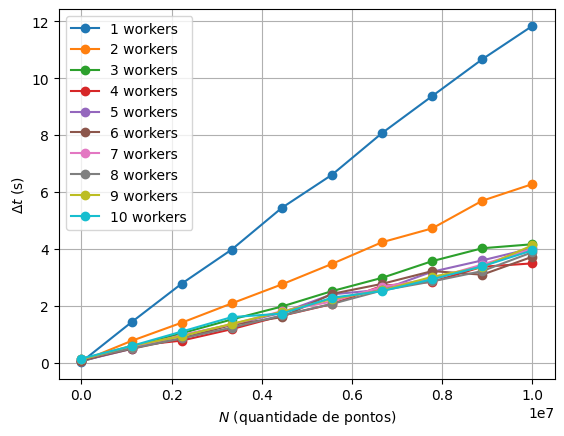

In [157]:
# plt.plot(Ns, eltime, '-o', label='Linear')
for i, t in zip(workers, eltime_parallel): plt.plot(Ns, t, '-o', label=f'{i} workers')
plt.xlabel('$N$ (quantidade de pontos)')
plt.ylabel('$\Delta t$ (s)')
plt.grid()
plt.legend()
plt.show()

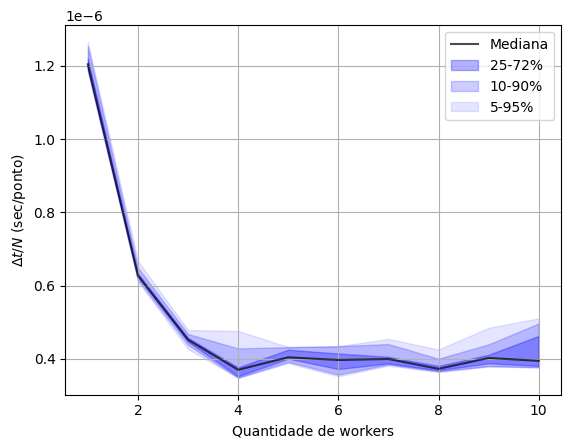

In [149]:
y = eltime_parallel.T[1:]/Ns[1:][..., np.newaxis]
plt.plot(workers, np.median(y, axis=0), 'k-', alpha=0.7, label='Mediana')
for pi, pf, a in ((25, 72, 0.3), (10, 90, 0.2), (5, 95, 0.1)):
    plt.fill_between(workers, np.percentile(y, pi, axis=0), np.percentile(y, pf, axis=0), color='blue', alpha=a, label=f'{pi}-{pf}%')
plt.legend()
plt.xlabel('Quantidade de workers')
plt.ylabel('$\Delta t / N$ (sec/ponto)')
plt.grid()
plt.show()

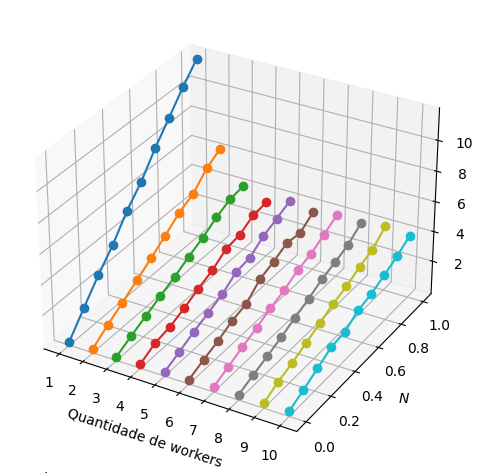

In [178]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fig.tight_layout()
for i, t in zip(workers, eltime_parallel): ax.plot(np.full(Ns.shape, i), Ns, t, '-o')
plt.xlabel('Quantidade de workers')
plt.xticks(workers)
plt.ylabel('$N$')
ax.set_zlabel('$\Delta t$ (s)')
plt.grid()
# plt.legend()
plt.show()